PatternInTime: Outlier Detection Testing

This notebook is dedicated to testing various methods aimed at identifying outliers within a given data series. Its primary objective is to serve as a research component of the main Analysis notebook.

In [44]:
import warnings
import pandas as pd
import numpy as np

# graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [45]:
def detect_outliers_z_score_method_scoring_method(data, threshold=3):
    """
    Detect outliers using z-score method and compute outlier score and magnitude.

    Parameters:
    - data: A list or array of numeric values.
    - threshold: The z-score threshold beyond which values are considered outliers. Default is 3.

    Returns:
    - A tuple containing the outlier score and magnitude:
      - outlier_score: A number between 0 and 1 indicating the proportion of data points
                       considered outliers based on the defined threshold.
                       0 signifies no outliers, and 1 indicates that all data points are outliers.
      - magnitude: The cumulative magnitude of the outliers in the data series,
                   providing insight into the overall impact or extent of the outliers present.
    """
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    outliers = np.sum(z_scores > threshold)
    magnitude = np.sum(z_scores[z_scores > threshold])

    outlier_score = min(1, outliers / len(data))  # Normalize to a score between 0 and 1

    return outlier_score, magnitude

In [46]:
def detect_outliers_iqr_scoring_method(data, threshold=1.5):
    """
    Detect outliers using the interquartile range (IQR) method.
    
    Parameters:
    - data: A list or array of numeric values.
    - threshold: The multiplier for the IQR. Values beyond
      threshold * IQR from the quartiles are considered outliers.
      Default is 1.5.
    
    Returns:
    - A number between 0 and 1 reflecting the presence and magnitude of outliers.
    """
    # Calculate the first and third quartiles
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    # Calculate the IQR
    iqr = q3 - q1
    
    # Determine the outlier cutoff
    cutoff = threshold * iqr
    
    # Find the indices of outliers
    outliers_count = sum(1 for value in data if value < q1 - cutoff or value > q3 + cutoff)
    
    # Calculate the proportion of outliers
    outliers_proportion = outliers_count / len(data)
    
    return outliers_proportion

In [47]:
def detect_outliers_iqr(data, k=1.5):
    """
    Detect outliers in the data using IQR (Interquartile Range) method.

    Parameters:
    data (numpy.ndarray): Input data as a numpy array.
    k (float): Coefficient to scale the IQR. Data points beyond k times the IQR
               from the first and third quartiles are considered outliers. Default is 1.5.

    Returns:
    numpy.ndarray: Boolean array indicating whether each data point is an outlier or not.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return (data < lower_bound) | (data > upper_bound)

### Testing on BasicDataSets
Here we test out different methods to determine which outlier detection or scoring method to use.
Options considered:
- IQR scoring
- Z_Score scoring
- Mean + STD combination
- IQR basic detection (used as the main method)

In [48]:
BasicTestingDataSets = (
    ("expected find - YES",[60,61,62,70,58,60,63]),
    ("expected find - YES",[60,59,62,71,58,60,63]),
    ("expected find - YES",[0,0,0,0,0,0,0,0,46,0,0,0,0,0]),
    ("expected find - NO",[60,61,62,63,58,60,63]),
    ("expected find - NO",[60,61,62,60,58,60,63]),
    ("expected find - YES", [60,61,62,60,70,59,60,50, 62,63]))

for expected, series in BasicTestingDataSets:
    print(f"{expected} for {series}")
    print(f"IQR: {detect_outliers_iqr_scoring_method(series)}")
    print(f"Z_Score: {detect_outliers_z_score_method_scoring_method(series)[0]}")
    print(f"MEAN: {np.mean(series)}, STD: {np.std(series)}, STD-MEAN: {np.std(series) - np.mean(series)}")
    outliers_iqr = detect_outliers_iqr(series)
    print("Outliers using IQR method:", any(outliers_iqr))
    print("                   ")

expected find - YES for [60, 61, 62, 70, 58, 60, 63]
IQR: 0.14285714285714285
Z_Score: 0.0
MEAN: 62.0, STD: 3.585685828003181, STD-MEAN: -58.41431417199682
Outliers using IQR method: True
                   
expected find - YES for [60, 59, 62, 71, 58, 60, 63]
IQR: 0.14285714285714285
Z_Score: 0.0
MEAN: 61.857142857142854, STD: 4.050699108216521, STD-MEAN: -57.806443748926334
Outliers using IQR method: True
                   
expected find - YES for [0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0]
IQR: 0.07142857142857142
Z_Score: 0.07142857142857142
MEAN: 3.2857142857142856, STD: 11.846811333667393, STD-MEAN: 8.561097047953108
Outliers using IQR method: True
                   
expected find - NO for [60, 61, 62, 63, 58, 60, 63]
IQR: 0.0
Z_Score: 0.0
MEAN: 61.0, STD: 1.6903085094570331, STD-MEAN: -59.30969149054297
Outliers using IQR method: False
                   
expected find - NO for [60, 61, 62, 60, 58, 60, 63]
IQR: 0.0
Z_Score: 0.0
MEAN: 60.57142857142857, STD: 1.4982983545287878,

### Evaluating Hourly Test Data with IQR Outlier Detection

Here, we analyze hourly test datasets using the IQR outlier detection method. We carefully examine and graph the results against pre-established expectations based on human expertise.

In [49]:
hourly_df = pd.DataFrame({"00:00":[0, 0, 2, 0], "01:00":[0, 0, 0, 0], "02:00":[0, 0, 0, 0],
                         "03:00":[0, 0, 0, 0], "04:00":[0, 0, 0, 0], "05:00":[0, 0, 1, 0],
                         "06:00":[0, 0, 1, 0], "07:00":[0, 0, 8, 2], "08:00":[7, 0, 9, 5],
                         "09:00":[10, 0, 2, 5], "10:00":[11, 0, 1, 6], "11:00":[0, 0, 1, 4],
                         "12:00":[0, 0, 4, 18], "13:00":[0, 0, 5, 7], "14:00":[0, 0, 2, 10],
                         "15:00":[13, 0, 2, 5], "16:00":[0, 42, 0, 5], "17:00":[0, 0, 0, 6],
                         "18:00":[0, 0, 1, 4], "19:00":[0, 0, 4, 3], "20:00":[0, 0, 9, 6],
                         "21:00":[0, 0, 14, 4], "22:00":[0, 0, 11, 5], "23:00":[0, 0, 9, 1]})

expected_outcomes = [True, True, False, False]
outcomes = []
outliers = []
outlier_columns = []


# Iterate over the rows and find outliers
for index, row in hourly_df.iterrows():
    # Detect outliers using IQR method
    outliers_iqr = detect_outliers_iqr(row.values)
    outcome = any(outliers_iqr)
    
    # Get the column names corresponding to outliers
    outlier_columns_iqr = hourly_df.columns[outliers_iqr].tolist()
    
    # Append outlier information to lists
    outcomes.append(outcome)
    outliers.append(row[outliers_iqr].values)
    outlier_columns.append(outlier_columns_iqr)
    
# Add outlier information as new columns to df
hourly_df['expected_outcome'] = expected_outcomes
hourly_df['outcome'] = outcomes
hourly_df['outliers'] = outliers
hourly_df['outlier_columns'] = outlier_columns

DataSeries: [ 0  0  0  0  0  0  0  0  7 10 11  0  0  0  0 13  0  0  0  0  0  0  0  0]
Outliers: [ 7 10 11 13], OutlierColumns:['08:00', '09:00', '10:00', '15:00']


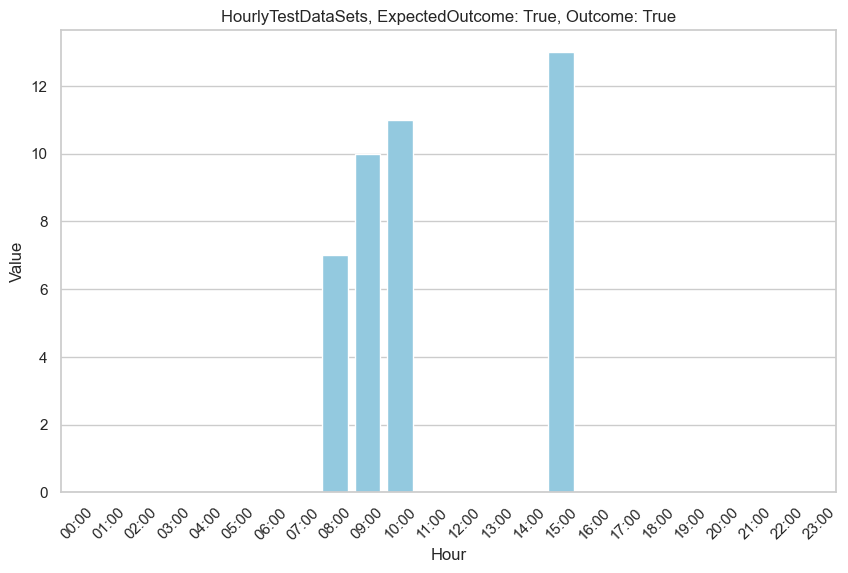

DataSeries: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 42  0  0  0  0  0  0  0]
Outliers: [42], OutlierColumns:['16:00']


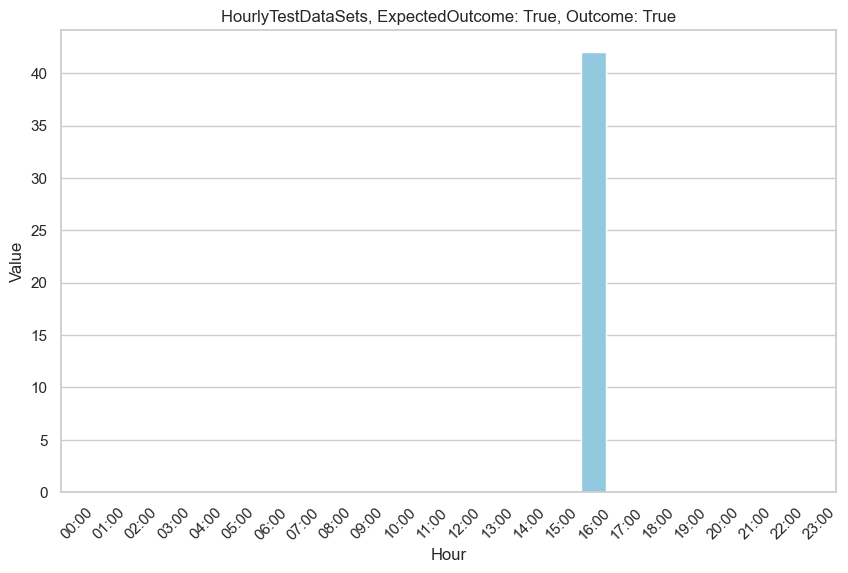

DataSeries: [ 2  0  0  0  0  1  1  8  9  2  1  1  4  5  2  2  0  0  1  4  9 14 11  9]
Outliers: [14], OutlierColumns:['21:00']


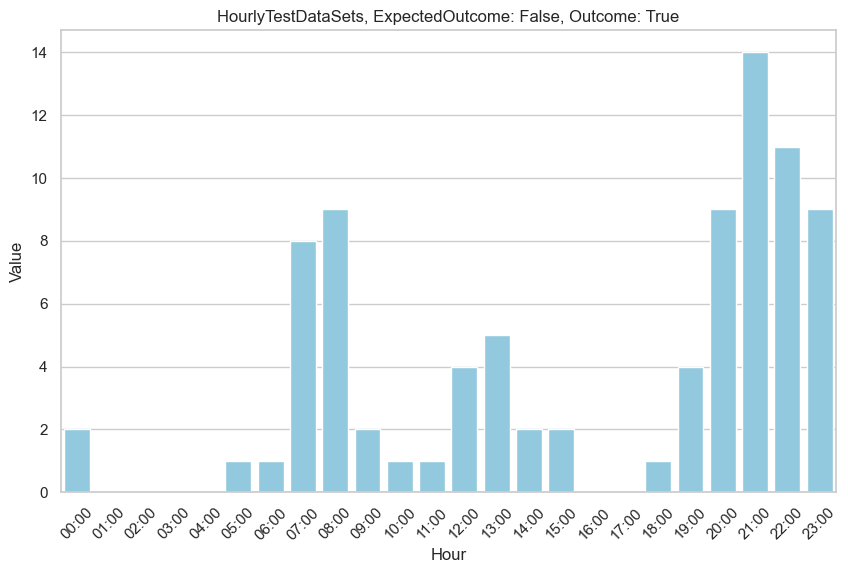

DataSeries: [ 0  0  0  0  0  0  0  2  5  5  6  4 18  7 10  5  5  6  4  3  6  4  5  1]
Outliers: [18], OutlierColumns:['12:00']


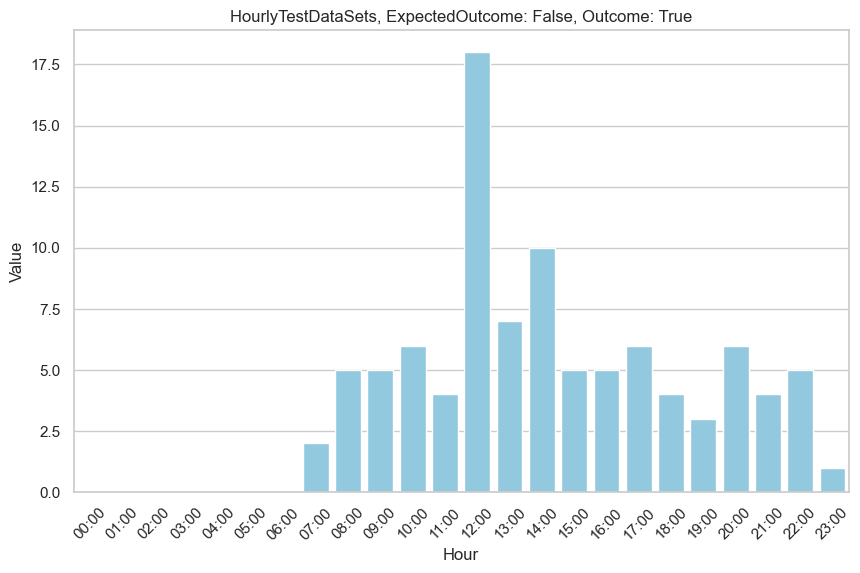

In [50]:
# Set the seaborn style for the plots
sns.set(style="whitegrid")

# Iterate over each row in series_df and results_df simultaneously
for (index1, series_row), (index2, results_row) in zip(hourly_df.iloc[:, :24].iterrows(), hourly_df.iloc[:, 24:].iterrows()):
    print(f"DataSeries: {series_row.values}")
    print(f"Outliers: {results_row.outliers}, OutlierColumns:{results_row.outlier_columns}")
    plt.figure(figsize=(10, 6))  # Set the figure size
    # Convert series_row to DataFrame for seaborn compatibility, reset index to use default numeric index
    sns.barplot(x=series_row.index, y=series_row.values, color="skyblue")  # Use a single color for all bars
    # Set the title 
    plt.title(f"HourlyTestDataSets, ExpectedOutcome: {results_row['expected_outcome']}, Outcome: {results_row['outcome']}")
    plt.xlabel('Hour')  # Set the x-axis label
    plt.ylabel('Value')  # Set the y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()  # Display the plot

### Evaluating Daily Test Data with IQR Outlier Detection

Here, we analyze daily test datasets using the IQR outlier detection method. We carefully examine and graph the results against pre-established expectations based on human expertise.

In [51]:
daily_df = pd.DataFrame(
    {"Monday":[10,4,69,7,0,7100],
     "Tuesday":[2,3,68,3,0,7200],
     "Wednesday":[2,2,68,1,0,5000],
     "Thursday":[3,2,63,4,0,8000],
     "Friday":[2,1,69,3,20,9500],
     "Saturday":[2,3,70,4,0,6300],
     "Sunday":[1,2,68,8,0,7500]}
)

expected_outcomes = [True, False, True, False, True, True]
outcomes = []
outliers = []
outlier_columns = []

# Iterate over the rows and find outliers
for index, row in daily_df.iterrows():
    # Detect outliers using IQR method
    outliers_iqr = detect_outliers_iqr(row.values)
    outcome = any(outliers_iqr)
    
    # Get the column names corresponding to outliers
    outlier_columns_iqr = daily_df.columns[outliers_iqr].tolist()
    
    # Append outlier information to lists
    outcomes.append(outcome)
    outliers.append(row[outliers_iqr].values)
    outlier_columns.append(outlier_columns_iqr)
    
# Add outlier information as new columns to df
daily_df['expected_outcome'] = expected_outcomes
daily_df['outcome'] = outcomes
daily_df['outliers'] = outliers
daily_df['outlier_columns'] = outlier_columns

DataSeries: [10  2  2  3  2  2  1]
Outliers: [10  1], OutlierColumns:['Monday', 'Sunday']


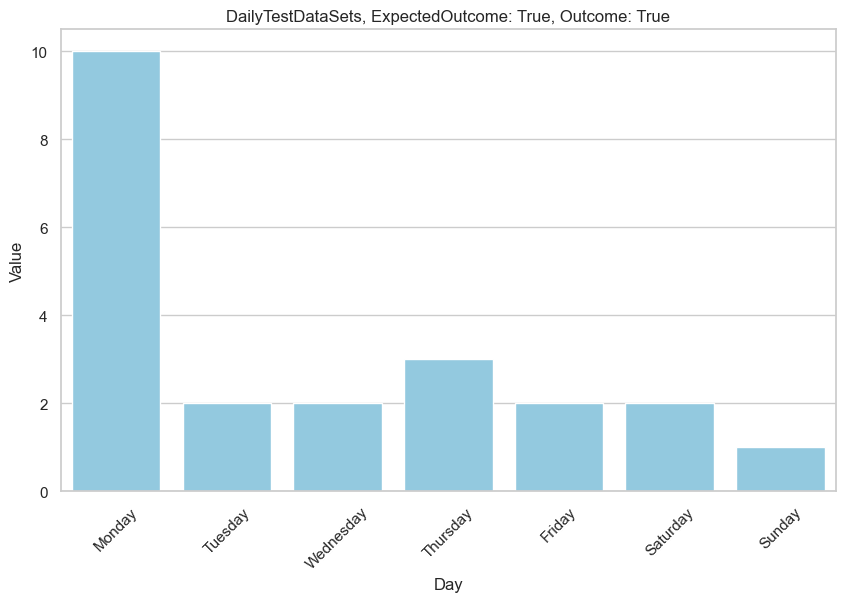

DataSeries: [4 3 2 2 1 3 2]
Outliers: [], OutlierColumns:[]


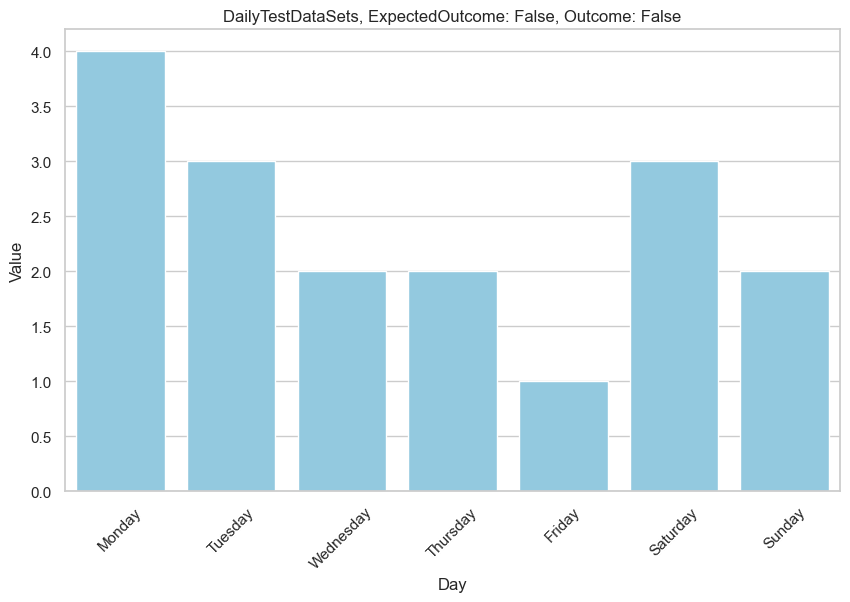

DataSeries: [69 68 68 63 69 70 68]
Outliers: [63], OutlierColumns:['Thursday']


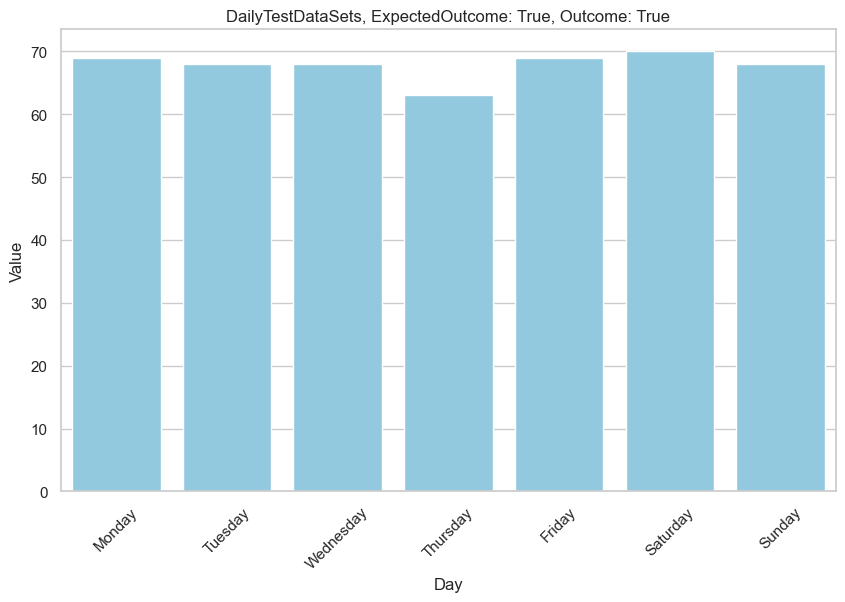

DataSeries: [7 3 1 4 3 4 8]
Outliers: [], OutlierColumns:[]


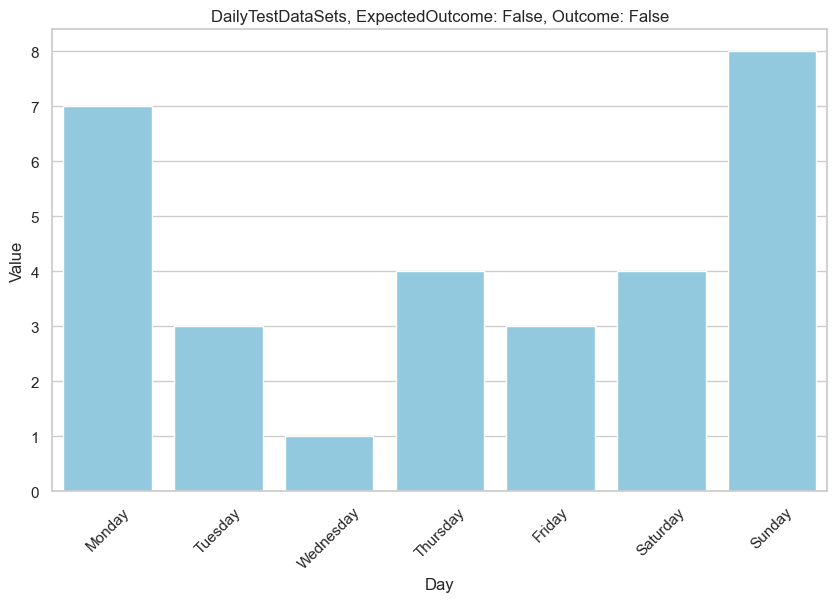

DataSeries: [ 0  0  0  0 20  0  0]
Outliers: [20], OutlierColumns:['Friday']


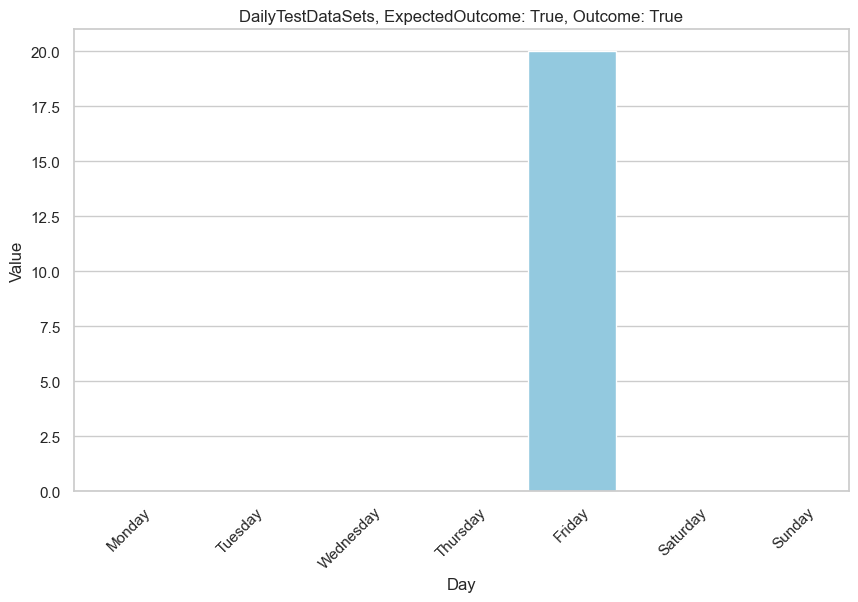

DataSeries: [7100 7200 5000 8000 9500 6300 7500]
Outliers: [5000 9500], OutlierColumns:['Wednesday', 'Friday']


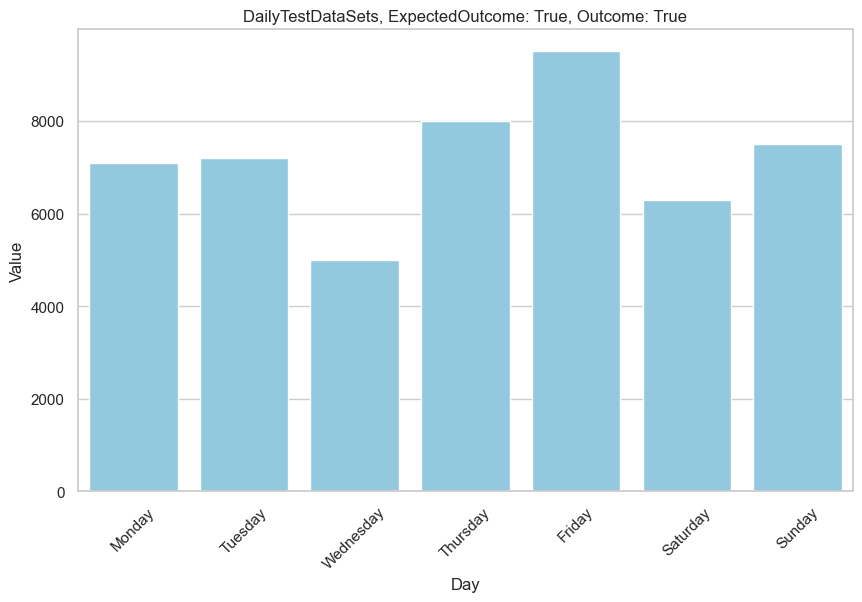

In [53]:
# Set the seaborn style for the plots
sns.set(style="whitegrid")

# Iterate over each row in series_df and results_df simultaneously
for (index1, series_row), (index2, results_row) in zip(daily_df.iloc[:, :7].iterrows(), daily_df.iloc[:, 7:].iterrows()):
    print(f"DataSeries: {series_row.values}")
    print(f"Outliers: {results_row.outliers}, OutlierColumns:{results_row.outlier_columns}")
    plt.figure(figsize=(10, 6))  # Set the figure size
    # Convert series_row to DataFrame for seaborn compatibility, reset index to use default numeric index
    sns.barplot(x=series_row.index, y=series_row.values, color="skyblue")  # Use a single color for all bars
    # Set the title 
    plt.title(f"DailyTestDataSets, ExpectedOutcome: {results_row['expected_outcome']}, Outcome: {results_row['outcome']}")
    plt.xlabel('Day')  # Set the x-axis label
    plt.ylabel('Value')  # Set the y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()  # Display the plot